In [1]:
# %% [markdown]
# ## 🚀 SFO 프로젝트 [2/2] - 모델 학습 및 저장
#
# - **전처리 완료된 CSV 파일 로드**
# - Train/Validation 데이터 분할 (시간 기반)
# - **LightGBM 최종 모델 학습** (Optuna 최적 파라미터 적용)
# - **검증 데이터에 대한 예측 및 MAE, R2 출력**
# - **학습된 모델 파일로 저장**
#
# **[시작 전 준비사항]**
# 1. `00_baseline_processed.ipynb` 스크립트를 먼저 실행하여 `df_manual_features_encoded.csv` 파일이 생성되어 있어야 합니다.
# 2. 필요한 라이브러리 설치: `pip install pandas numpy lightgbm scikit-learn joblib`
#

# %%
import pandas as pd
import numpy as np
import os
import lightgbm as lgb
from sklearn.metrics import mean_absolute_error, r2_score
import joblib # 모델 저장을 위한 라이브러리

# --- 0. 설정 및 파일 경로 정의 ---
input_processed_csv_file = '../data/time_series.csv' # 중요!! 경로 설정해줘야함!!
model_save_path = '../data/optuna_lightgbm_model.pkl' # 학습된 모델 저장 경로

target_column = 'T일 예정 수주량'

print("--- [SFO 프로젝트 [2/2] - 모델 학습 및 저장 시작] ---")


# --- 1단계: 전처리된 데이터 로드 ---
print(f"\n--- [1단계: 전처리된 데이터 '{input_processed_csv_file}' 로드 시작] ---")
df_manual_features_encoded = None
try:
    if not os.path.exists(input_processed_csv_file):
        raise FileNotFoundError(f"🚨 오류: 입력 파일 '{input_processed_csv_file}'을(를) 찾을 수 없습니다. \n   [파일 1: 01_preprocess_and_save.py] 스크립트를 먼저 실행했는지 확인하세요.")
    
    df_manual_features_encoded = pd.read_csv(input_processed_csv_file)
    
    # !! 매우 중요 !!
    # CSV로 저장하면서 문자열이 된 'Date' 컬럼을 다시 datetime 객체로 변환합니다.
    # 시간 기반 데이터 분할(splitting)을 위해 필수입니다.
    df_manual_features_encoded['Date'] = pd.to_datetime(df_manual_features_encoded['Date'])
    
    print(f"✅ 전처리된 데이터 로드 완료 (shape: {df_manual_features_encoded.shape})")
    print(f"   'Date' 컬럼 타입: {df_manual_features_encoded['Date'].dtype}")

except FileNotFoundError as e:
    print(f"🚨 {e}")
except Exception as e:
    print(f"🚨 1단계 데이터 로드 중 오류: {e}")
    df_manual_features_encoded = None


--- [SFO 프로젝트 [2/2] - 모델 학습 및 저장 시작] ---

--- [1단계: 전처리된 데이터 '../data/time_series.csv' 로드 시작] ---
✅ 전처리된 데이터 로드 완료 (shape: (10624, 49))
   'Date' 컬럼 타입: datetime64[ns]


In [2]:
# --- 2단계: LightGBM 최종 모델 학습 및 예측 ---
final_model = None

if df_manual_features_encoded is not None and not df_manual_features_encoded.empty:
    print("\n--- [2단계: LightGBM 최종 모델 학습 및 예측 시작] ---")
    try:
        # 2.1. 데이터 분할 (Train/Validation - 시간 기반)
        # 'Date' 컬럼이 datetime 타입이어야 sort_values가 올바르게 작동합니다.
        df_manual_features_encoded = df_manual_features_encoded.sort_values(by='Date')
        
        train_ratio = 0.8
        split_idx = int(len(df_manual_features_encoded) * train_ratio)

        train_df = df_manual_features_encoded.iloc[:split_idx]
        val_df = df_manual_features_encoded.iloc[split_idx:]

        # ▼▼▼▼▼ [수정된 부분] ▼▼▼▼▼
        # 'object' 타입의 원본 Product_Number 컬럼을 피처에서 제외시킵니다.
        features_to_exclude_from_X = ['Date', target_column, 'Product_Number']
        # ▲▲▲▲▲ [수정된 부분] ▲▲▲▲▲

        X_train = train_df.drop(columns=features_to_exclude_from_X)
        y_train = train_df[target_column]
        X_val = val_df.drop(columns=features_to_exclude_from_X)
        y_val = val_df[target_column]
        
        # (참고) 만약 'DayOfWeek' 원본 컬럼도 남아있다면 위 리스트에 'DayOfWeek'도 추가해야 할 수 있습니다.
        # features_to_exclude_from_X = ['Date', target_column, 'Product_Number', 'DayOfWeek']

        print(f"2.1. 데이터 분할 완료: Train_X: {X_train.shape}, Train_y: {y_train.shape}, Val_X: {X_val.shape}, Val_y: {y_val.shape}")
        print(f"   - 최종 모델 학습에 사용될 피처 개수: {X_train.shape[1]}개")


        # 2.2. LightGBM 최종 모델 학습 (Optuna 최적 파라미터 적용)
        print("\n2.2. LightGBM 최종 모델 학습 시작 (Optuna 최적 파라미터)...")
        # --- 여기에 Optuna로 찾은 최종 최적 파라미터를 입력하세요! ---
        # 예시 파라미터입니다. 발표의 MAE 11.92, R2 0.957을 달성한 파라미터로 교체해야 합니다.
        lgbm_final_params = {
            'objective': 'regression_l1', # MAE를 직접 최적화
            'metric': 'mae',
            'n_estimators': 2000,         # 충분히 큰 값 설정 후 early stopping
            'learning_rate': 0.027719430829110773,
            'num_leaves': 100,
            'max_depth': 11,
            'min_child_samples': 11,
            'subsample': 0.6,
            'colsample_bytree': 0.7,
            'random_state': 42,
            'reg_alpha': 0.42067115008505107,
            'reg_lambda': 0.05110000164534667,
            'lambda_l2': 0.9,
            'min_split_gain': 0.05,
            'n_jobs': -1,
            'verbose': -1,                # 학습 과정 메시지 출력 억제
            'boosting_type': 'gbdt',
        }
        '''
        최적의 하이퍼 파라미터:
        {'learning_rate': 0.027719430829110773, 
        'num_leaves': 100,
        'max_depth': 11, 
        'subsample': 0.6, 
        'colsample_bytree': 0.7, 
        'min_child_samples': 11, 
        'reg_alpha': 0.42067115008505107, 
        'reg_lambda': 0.05110000164534667}

        
        '''
        final_model = lgb.LGBMRegressor(**lgbm_final_params)
        final_model.fit(X_train, y_train,
                        eval_set=[(X_train, y_train),(X_val, y_val)],
                        eval_metric='mae',
                        callbacks=[lgb.early_stopping(100, verbose=False)]) # 100회 동안 개선 없으면 조기 종료

        print("\n✅ LightGBM 최종 모델 학습 완료!")

        # 2.3. 검증 데이터에 대한 예측 및 성능 평가
        val_preds = final_model.predict(X_val)
        final_mae = mean_absolute_error(y_val, val_preds)
        final_r2 = r2_score(y_val, val_preds)
        print(f"   - 최종 모델 검증 MAE: {final_mae:.2f}")
        print(f"   - 최종 모델 검증 R2: {final_r2:.3f}")

        # 2.4. 학습된 모델 저장
        try:
            joblib.dump(final_model, model_save_path)
            print(f"✅ 학습된 최종 모델이 '{model_save_path}'에 저장되었습니다.")
        except Exception as e:
            print(f"🚨 모델 저장 중 오류 발생: {e}")

        # 2.5. (선택 사항) 저장된 모델 불러오기 예시
        # loaded_model = joblib.load(model_save_path)
        # print(f"✅ 모델 '{model_save_path}' 불러오기 완료.")
        # loaded_preds = loaded_model.predict(X_val)
        # print(f"   - 불러온 모델로 예측한 MAE: {mean_absolute_error(y_val, loaded_preds):.2f}")


    except Exception as e:
        print(f"🚨 2단계 LightGBM 모델 학습 및 예측 중 오류 발생: {e}")
else:
    print("🚨 1단계 데이터 로드 실패로 2단계 모델 학습 및 예측을 시작할 수 없습니다.")

print("\n--- [SFO 프로젝트 [2/2] - 모델 학습 및 저장 종료] ---")


--- [2단계: LightGBM 최종 모델 학습 및 예측 시작] ---
2.1. 데이터 분할 완료: Train_X: (8499, 46), Train_y: (8499,), Val_X: (2125, 46), Val_y: (2125,)
   - 최종 모델 학습에 사용될 피처 개수: 46개

2.2. LightGBM 최종 모델 학습 시작 (Optuna 최적 파라미터)...

✅ LightGBM 최종 모델 학습 완료!
   - 최종 모델 검증 MAE: 10.17
   - 최종 모델 검증 R2: 0.971
✅ 학습된 최종 모델이 '../data/optuna_lightgbm_model.pkl'에 저장되었습니다.

--- [SFO 프로젝트 [2/2] - 모델 학습 및 저장 종료] ---



[evals_result 구조 확인]
 - training / l1 : 2000 entries
 - valid_1 / l1 : 2000 entries


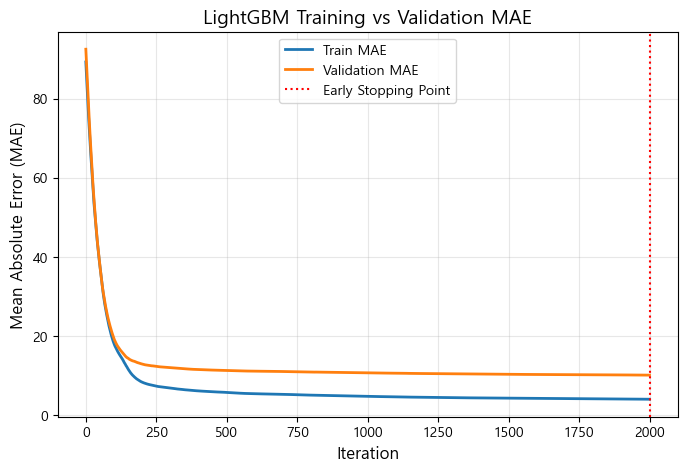

In [3]:
import matplotlib.pyplot as plt

# --- LightGBM의 학습 로그 가져오기 ---
evals_result = final_model.evals_result_

# evals_result 구조 확인 (디버깅용)
print("\n[evals_result 구조 확인]")
for dataset_name, metrics in evals_result.items():
    for metric_name in metrics.keys():
        print(f" - {dataset_name} / {metric_name} : {len(metrics[metric_name])} entries")

plt.rcParams['font.family'] = 'Malgun Gothic'  # Windows
plt.rcParams['axes.unicode_minus'] = False

# --- 손실 곡선 시각화 ---
plt.figure(figsize=(8, 5))
plt.plot(evals_result['training']['l1'], label='Train MAE', linewidth=2)
plt.plot(evals_result['valid_1']['l1'], label='Validation MAE', linewidth=2)
plt.axvline(final_model.best_iteration_, color='red', linestyle=':', label='Early Stopping Point')
plt.title('LightGBM Training vs Validation MAE', fontsize=14)
plt.xlabel('Iteration', fontsize=12)
plt.ylabel('Mean Absolute Error (MAE)', fontsize=12)
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()


In [4]:
import shap # SHAP 분석을 위한 라이브러리
import matplotlib.pyplot as plt
import seaborn as sns

In [5]:
# matplotlib 한글 폰트 설정 (필요시)
plt.rcParams['font.family'] = 'Malgun Gothic' # Windows 기준
# plt.rcParams['font.family'] = 'AppleGothic' # Mac 기준
plt.rcParams['axes.unicode_minus'] = False # 음수 부호 깨짐 방지

In [12]:
# ===== SHAP 안전 실행 원샷 루틴 (leaf coverage fix) =====
import numpy as np
import pandas as pd
import shap
import warnings
warnings.filterwarnings("ignore")

def _align_like_train(X_val, X_train):
    Xv = X_val.reindex(columns=X_train.columns)
    # dtype 정렬
    for c in X_train.columns:
        if pd.api.types.is_categorical_dtype(X_train[c]):
            Xv[c] = Xv[c].astype('category')
            Xv[c] = Xv[c].cat.set_categories(X_train[c].cat.categories)
        elif pd.api.types.is_numeric_dtype(X_train[c]):
            if not pd.api.types.is_numeric_dtype(Xv[c]):
                Xv[c] = pd.to_numeric(Xv[c], errors="coerce")
    # 결측 보정
    for c in X_train.columns:
        if pd.api.types.is_numeric_dtype(X_train[c]):
            fill = np.nanmedian(X_train[c].values.astype(float))
        else:
            fill = X_train[c].mode().iloc[0] if not X_train[c].mode().empty else ""
        Xv[c] = Xv[c].fillna(fill)
    return Xv

def _max_additivity_diff(explainer, shap_values, pred):
    exp = explainer.expected_value
    if isinstance(exp, list):
        exp = exp[0]
    if isinstance(shap_values, list):
        shap_values = shap_values[0]
    return float(np.max(np.abs(exp + shap_values.sum(-1) - pred)))

def _build_explainer(final_model, X_train, mode, bg_strategy):
    """
    mode: 'margin' | 'probability' | 'raw-regression'
    bg_strategy: 'none' | 'interventional'
    """
    # 출력 모드
    if mode == "margin":
        exp_kwargs = {"model_output": "margin"}
    elif mode == "probability":
        exp_kwargs = {"model_output": "probability"}
    else:
        exp_kwargs = {"model_output": "raw"}

    # 배경 셋 전략
    if bg_strategy == "none":
        # 배경셋을 주지 않고 tree_path_dependent로 (leaf coverage 에러 회피)
        explainer = shap.TreeExplainer(
            final_model,
            feature_perturbation="tree_path_dependent",
            **exp_kwargs,
        )
    else:
        # interventional + 샘플 배경셋(최대 256행)
        bg = shap.utils.sample(X_train, nsamples=min(256, len(X_train)), random_state=0)
        explainer = shap.TreeExplainer(
            final_model,
            data=bg,
            feature_perturbation="interventional",
            **exp_kwargs,
        )
    return explainer

def run_shap_safely(final_model, X_train, X_val, sample_size=32, tolerance=1e-3):
    # 0) 정렬/동일화
    X_valA = _align_like_train(X_val.copy(), X_train)
    assert list(X_valA.columns) == list(X_train.columns), "열 불일치 발생"

    # 1) 모델 종류 판별
    is_classifier = hasattr(final_model, "predict_proba")

    # 2) 스모크 샘플
    n = len(X_valA)
    if n == 0:
        raise ValueError("X_val이 비어있습니다.")
    X_sm = X_valA.iloc[:min(sample_size, n)]

    # 3) 시도할 조합들(배경셋 전략 x 출력 스케일)
    tried = []
    configs = []
    if is_classifier:
        # (mode, bg_strategy, pred_selector)
        configs += [
            ("margin", "none",       {"raw_score": True,  "use_proba": False}),
            ("margin", "interventional", {"raw_score": True,  "use_proba": False}),
            ("probability", "interventional", {"raw_score": False, "use_proba": True}),
        ]
    else:
        configs += [
            ("raw-regression", "none",            {"raw_score": False, "use_proba": False}),
            ("raw-regression", "interventional",  {"raw_score": False, "use_proba": False}),
        ]

    best = None
    last_err = None

    for mode, bg_strategy, pred_conf in configs:
        tried.append((mode, bg_strategy))
        explainer = _build_explainer(final_model, X_train, mode, bg_strategy)

        # 예측 스케일 맞추기
        if is_classifier and pred_conf["use_proba"]:
            proba = final_model.predict_proba(X_sm)
            pred = proba[:, 1] if proba.ndim == 2 and proba.shape[1] >= 2 else proba.ravel()
        elif is_classifier and pred_conf["raw_score"]:
            pred = final_model.predict(X_sm, raw_score=True)
        else:
            pred = final_model.predict(X_sm)

        try:
            sv = explainer.shap_values(X_sm, check_additivity=True)
            diff = _max_additivity_diff(explainer, sv, pred)
            if diff <= tolerance or (np.isfinite(diff) and diff < 1e-2):
                best = (mode, bg_strategy, explainer, pred_conf)
                break
        except Exception as e:
            last_err = e
            continue

    if best is None:
        # 마지막 수단: 가장 보수적인 설정으로 additivity 끄고 전체 실행
        mode, bg_strategy, _ = configs[0]
        explainer = _build_explainer(final_model, X_train, mode, bg_strategy)
        shap_values = explainer.shap_values(X_valA, check_additivity=False)
        return {
            "status": "FORCED_NO_CHECK",
            "mode": mode,
            "bg": bg_strategy,
            "explainer": explainer,
            "X_val_aligned": X_valA,
            "shap_values": shap_values,
            "note": f"스모크 미통과 → check_additivity=False로 진행 (last_err={repr(last_err)})",
            "tried": tried,
        }

    # 스모크 통과 설정으로 전체 실행
    mode, bg_strategy, explainer, pred_conf = best
    shap_values = explainer.shap_values(X_valA, check_additivity=True)

    # 전체 additivity 재확인
    if is_classifier and pred_conf.get("use_proba", False):
        proba_full = final_model.predict_proba(X_valA)
        pred_full = proba_full[:, 1] if proba_full.ndim == 2 and proba_full.shape[1] >= 2 else proba_full.ravel()
    elif is_classifier and pred_conf.get("raw_score", False):
        pred_full = final_model.predict(X_valA, raw_score=True)
    else:
        pred_full = final_model.predict(X_valA)

    full_diff = _max_additivity_diff(explainer, shap_values, pred_full)

    return {
        "status": "OK",
        "mode": mode,
        "bg": bg_strategy,
        "explainer": explainer,
        "X_val_aligned": X_valA,
        "shap_values": shap_values,
        "additivity_diff": float(full_diff),
        "tried": tried,
    }


In [13]:
from IPython.display import display


--- [3. SHAP 분석 시작] ---
3.1 SHAP Explainer 생성 및 SHAP 값 계산(안전 모드)...
   status=OK | mode=raw-regression | additivity_diff=1.0345502232667059e-11

3.2 전역적 피처 중요도 (Bar Plot)...


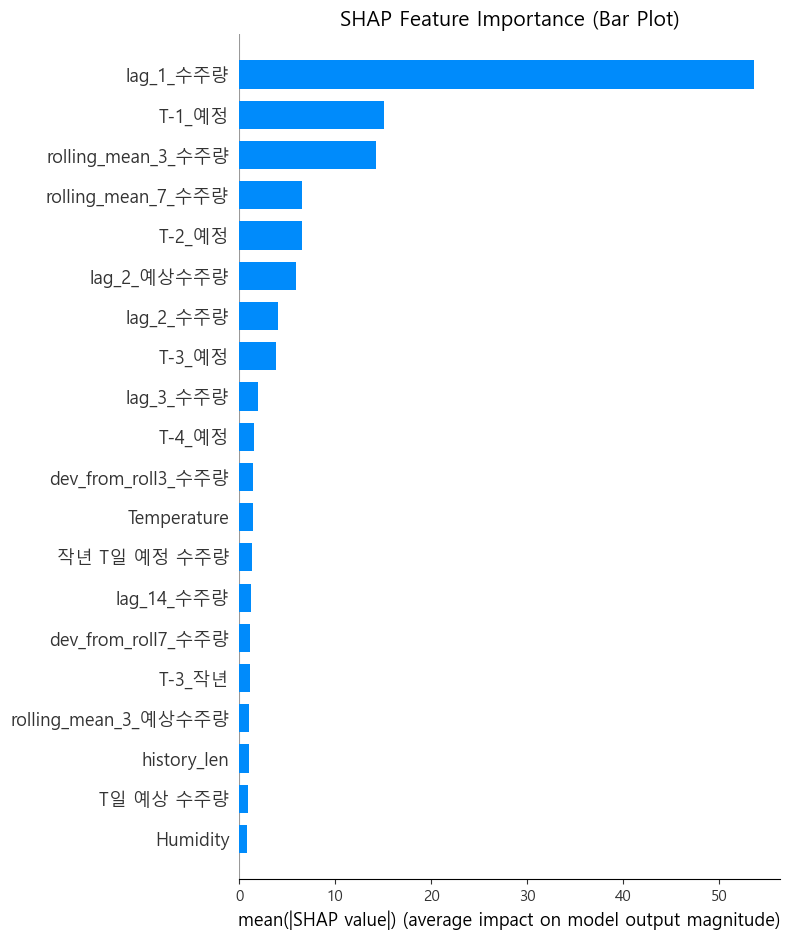


3.3 SHAP Summary Plot...


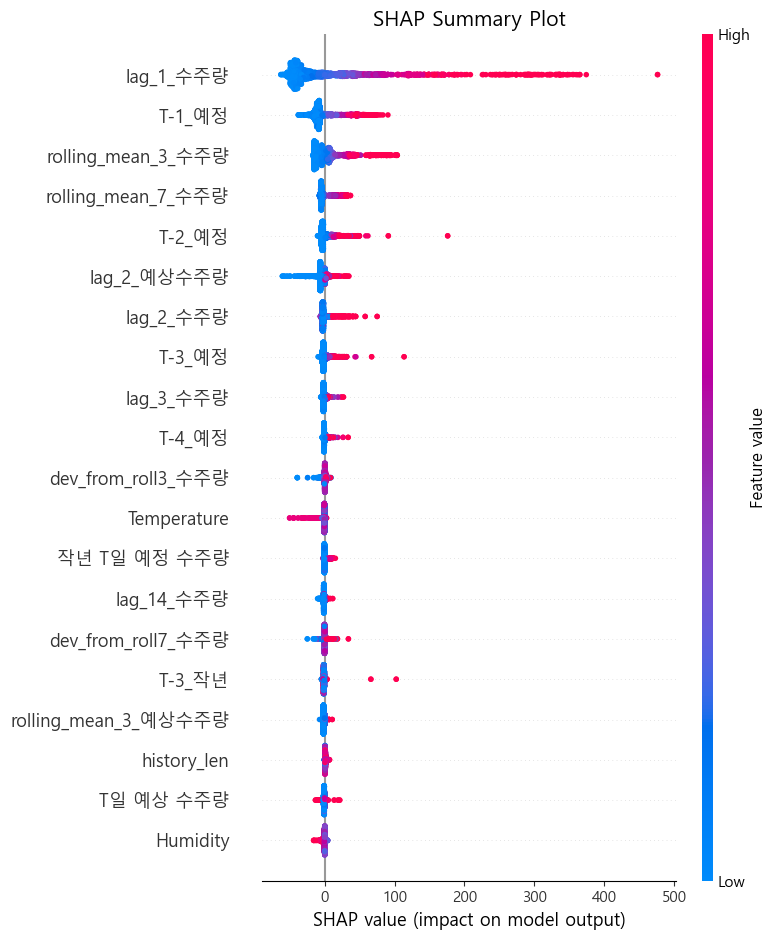


3.4 특정 예측에 대한 지역적 설명 (Force Plot)...



3.5 상위 3개 피처 Dependency Plot...
   - 'lag_1_수주량'


<Figure size 800x600 with 0 Axes>

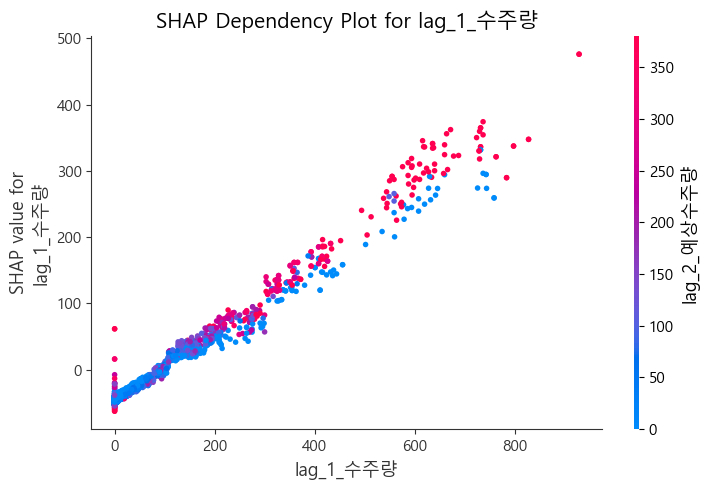

   - 'T-1_예정'


<Figure size 800x600 with 0 Axes>

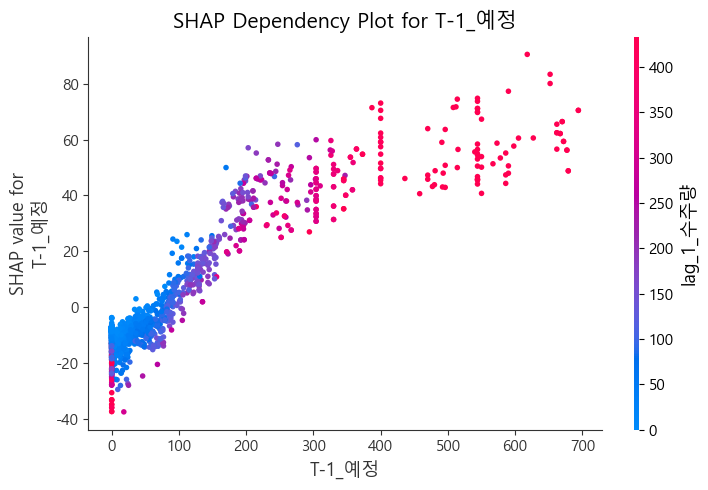

   - 'rolling_mean_3_수주량'


<Figure size 800x600 with 0 Axes>

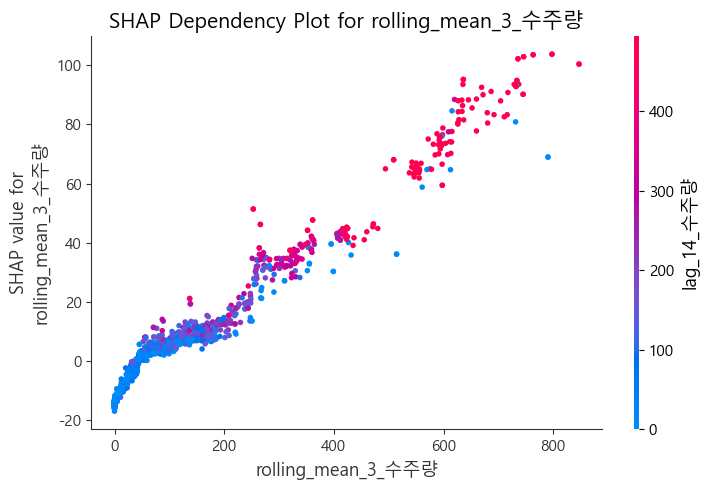


--- [SHAP 분석 완료] ---


In [14]:
# ## 3. SHAP (SHapley Additive exPlanations) 분석
# - 학습된 LightGBM 모델의 피처 중요도를 SHAP 값을 통해 분석합니다.
# - 전체 피처의 전역적 중요도 및 특정 예측에 대한 지역적 설명을 시각화합니다.

import shap, numpy as np, matplotlib.pyplot as plt

print("\n--- [3. SHAP 분석 시작] ---")

if 'final_model' not in locals() or final_model is None:
    print("🚨 'final_model'이 존재하지 않습니다. 이전 단계를 먼저 실행해주세요.")
elif 'X_val' not in locals() or X_val is None:
    print("🚨 'X_val' 데이터가 존재하지 않습니다. 이전 단계를 먼저 실행해주세요.")
else:
    print("3.1 SHAP Explainer 생성 및 SHAP 값 계산(안전 모드)...")
    result = run_shap_safely(final_model, X_train, X_val, sample_size=32, tolerance=1e-3)
    print(f"   status={result['status']} | mode={result.get('mode')} | additivity_diff={result.get('additivity_diff')}")

    explainer = result["explainer"]
    shap_values = result["shap_values"]
    Xv = result["X_val_aligned"]

    print("\n3.2 전역적 피처 중요도 (Bar Plot)...")
    plt.figure(figsize=(10, 8))
    shap.summary_plot(shap_values, Xv, plot_type="bar", show=False)
    plt.title('SHAP Feature Importance (Bar Plot)', fontsize=15)
    plt.tight_layout()
    plt.show()

    print("\n3.3 SHAP Summary Plot...")
    plt.figure(figsize=(12, 10))
    shap.summary_plot(shap_values, Xv, show=False)
    plt.title('SHAP Summary Plot', fontsize=15)
    plt.tight_layout()
    plt.show()

    print("\n3.4 특정 예측에 대한 지역적 설명 (Force Plot)...")
    sample_idx = 0
    base_value = explainer.expected_value[0] if isinstance(explainer.expected_value, list) else explainer.expected_value

    shap.initjs()
    # shap_values가 리스트(다중클래스/확률모드)일 가능성 처리
    sv_for_force = shap_values[0][sample_idx] if isinstance(shap_values, list) else shap_values[sample_idx]
    display(shap.force_plot(base_value, sv_for_force, Xv.iloc[sample_idx]))

    print("\n3.5 상위 3개 피처 Dependency Plot...")
    current_sv = shap_values[0] if isinstance(shap_values, list) else shap_values
    mean_abs = np.abs(current_sv).mean(axis=0)
    top_idx = mean_abs.argsort()[-3:][::-1]
    top_features = Xv.columns[top_idx]

    for feature in top_features:
        print(f"   - '{feature}'")
        plt.figure(figsize=(8, 6))
        shap.dependence_plot(feature, current_sv, Xv, interaction_index="auto", show=False)
        plt.title(f'SHAP Dependency Plot for {feature}', fontsize=15)
        plt.tight_layout()
        plt.show()

    print("\n--- [SHAP 분석 완료] ---")
